In [244]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import torch 
import torch.nn as nn
import os
from PIL import Image, ImageDraw
import numpy as np
from matplotlib.patches import Polygon
import torch.optim as optim
import torchvision.transforms as transforms
import albumentations as A
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import random 
import matplotlib.patches as patches
import skimage.draw 
import tifffile 
import shutil

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# cristian path 
base_dir = '/home/csalitre/school/ecgr-5106/final-project/' 


In [245]:
file_path_train = base_dir + '/semantic-segmentation/data/train/_annotations.coco.json'
file_path_valid = base_dir + '/semantic-segmentation/data/valid/_annotations.coco.json'   
file_paht_test = base_dir + '/semantic-segmentation/data/test/_annotations.coco.json'

# Doc file JSON
with open(file_path_train, 'r') as file:
    data_train = json.load(file)

with open(file_path_valid, 'r') as file:
    data_valid = json.load(file)

with open(file_paht_test, 'r') as file:
    data_test = json.load(file) 

for img in data_train['images'][:5]:
    print(img['file_name'])

data_train['categories']

2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg
2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg
2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg
2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg
2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg


[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [246]:
def draw_mask(img_names, data):
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))

    for i, img_name in enumerate(img_names):
        img = cv2.imread(img_name)
        img_filename = os.path.basename(img_name)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_mask = [mask for mask in data['annotations'] if mask['image_id'] == img_id]
        points_list = img_mask[0]['segmentation']
        points = np.array(points_list, np.int32)
        points = points.reshape((-1, 1, 2))

        cv2.polylines(img, [points], True,(0, 0, 255), 3)

        ax[i//2, i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()


In [247]:
# Load train images
img_train_dir = base_dir + '/semantic-segmentation/data/train/'
all_train_img_files = [os.path.join(img_train_dir, img['file_name']) for img in data_train['images']]

# Load valid images
img_valid_dir = base_dir + '/semantic-segmentation/data/valid/'
all_valid_img_files = [os.path.join(img_valid_dir, img['file_name']) for img in data_valid['images']]

# Load test images
img_test_dir = base_dir + '/semantic-segmentation/data/test/'
all_test_img_files = [os.path.join(img_test_dir, img['file_name']) for img in data_test['images']]
                      

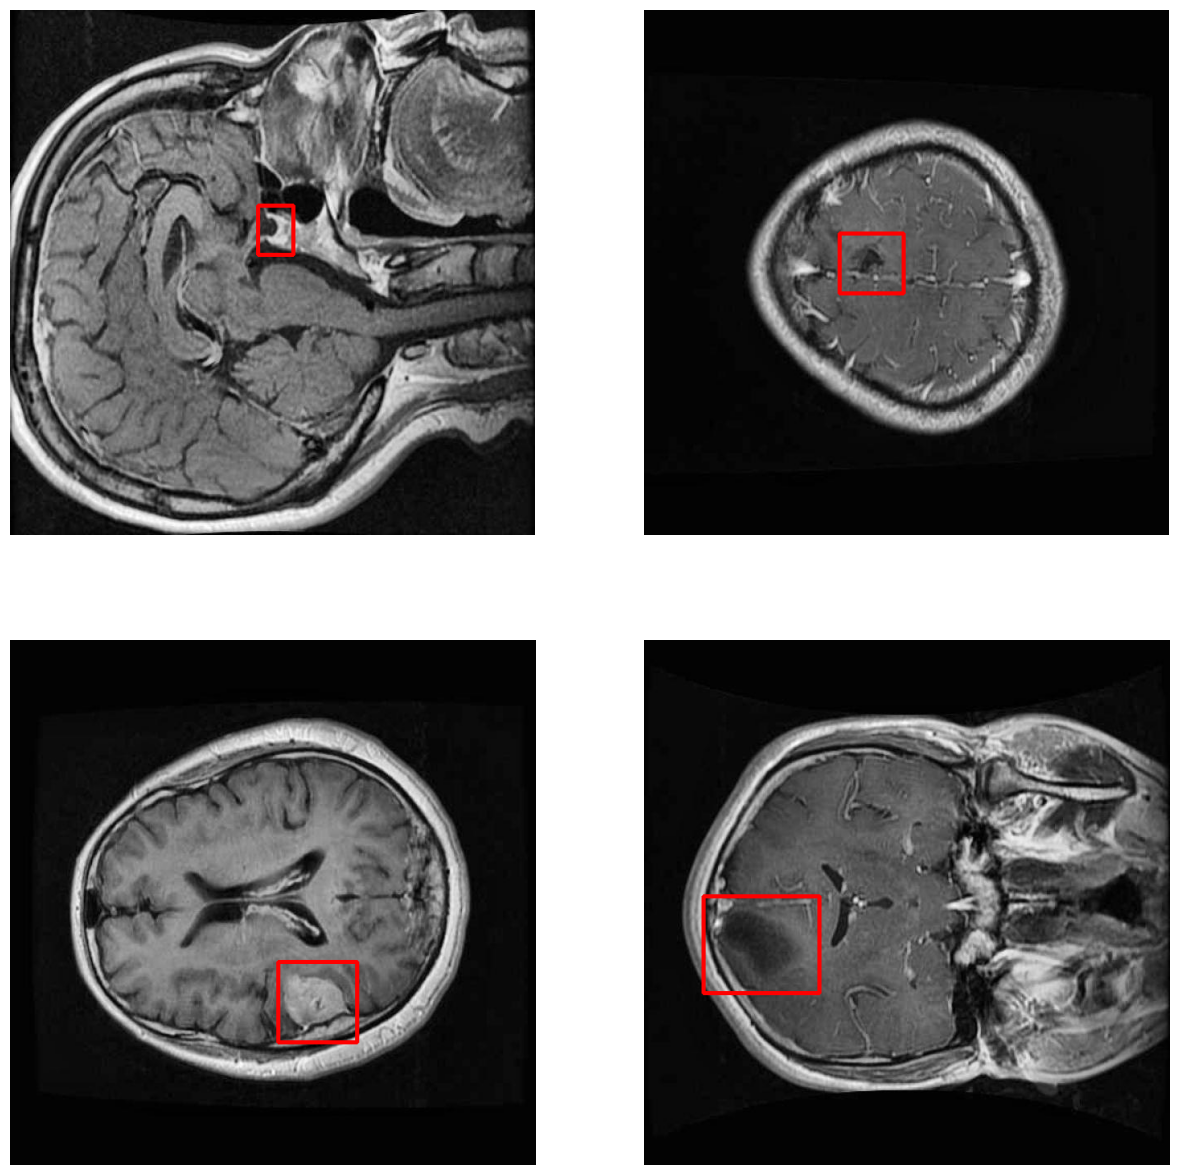

In [248]:
# plot random masked image
random_file = random.sample(all_train_img_files, 4)
draw_mask(random_file, data_train)

In [249]:
def create_mask(image_info, annotations, output_folder, max_print=3):
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    obj_number = 1
    printed_masks = 0 
    
    for ann in annotations:
        if image_info['id'] == ann['image_id']:
            for seg_idx, seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                seg_mask = np.zeros(mask_np.shape, dtype=np.uint8)
                seg_mask[rr, cc] = 255
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if we have printed the maximum number of masks 


def main(json_file,mask_output_folder,image_output_folder,original_image_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)
        
    images = data['images']
    annotations = data['annotations']

     # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        
        ## learn how to op
        shutil.copy2(original_image_path, new_image_path)

In [251]:
# seperate original images and masks
original_image_dir = base_dir + '/semantic-segmentation/data/train/'
json_file = base_dir + '/semantic-segmentation/data/train/_annotations.coco.json'
mask_output_folder = '../train2/masks'
image_output_folder = '../train2/images'
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = base_dir + '/semantic-segmentation/data/valid/'
json_file = base_dir + '/semantic-segmentation/data/valid/_annotations.coco.json'  
mask_output_folder = '../valid2/masks'
image_output_folder = '../valid2/images'
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = base_dir + '/semantic-segmentation/data/test/'
json_file = base_dir + '/semantic-segmentation/data/test/_annotations.coco.json'
mask_output_folder = '../test2/masks'
image_output_folder = '../test2/images'
main(json_file, mask_output_folder, image_output_folder, original_image_dir)


In [252]:
def compare_folders(folder1, folder2, folder3):
    for folder_path in [folder1, folder2, folder3]:
        folder_items = os.listdir(folder_path)
        other_folders = [f for f in [folder1, folder2, folder3] if f != folder_path]
        for item in folder_items:
            corresponding_found = False
            for other_folder in other_folders:
                if any(item[:4] == o[:4] for o in os.listdir(other_folder)):
                    corresponding_found = True
                    break
            if not corresponding_found:
                print(f"Corresponding item for {item} not found in other folders.")
                item_path = os.path.join(folder_path, item)
                os.remove(item_path)
                print(f"Deleted {item}")

folder1_path = os.path.join(base_dir, 'semantic-segmentation/data/train')
folder2_path = os.path.join(base_dir, 'semantic-segmentation/data/valid')
folder3_path = os.path.join(base_dir, 'semantic-segmentation/data/test')

# Delete original images
#compare_folders(folder1_path, folder2_path, folder3_path)


In [253]:
class MatchDataset:
    def __init__(self,root_dir):
        self.root = root_dir
        self.image_f = os.path.join(root_dir,'images')
        self.mask_f = os.path.join(root_dir,'masks')
        self.images = sorted(os.listdir(self.image_f))
        self.masks = sorted(os.listdir(self.mask_f))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img_name = self.images[index]
        mask_name = self.masks[index]
        img_path = os.path.join(self.image_f,img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        mask_path = os.path.join(self.mask_f,mask_name)
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        
        return img,mask

dataset = MatchDataset(base_dir + 'semantic-segmentation/train2/')
img,mask = dataset[0]
img.shape, mask.shape

((640, 640, 3), (640, 640))

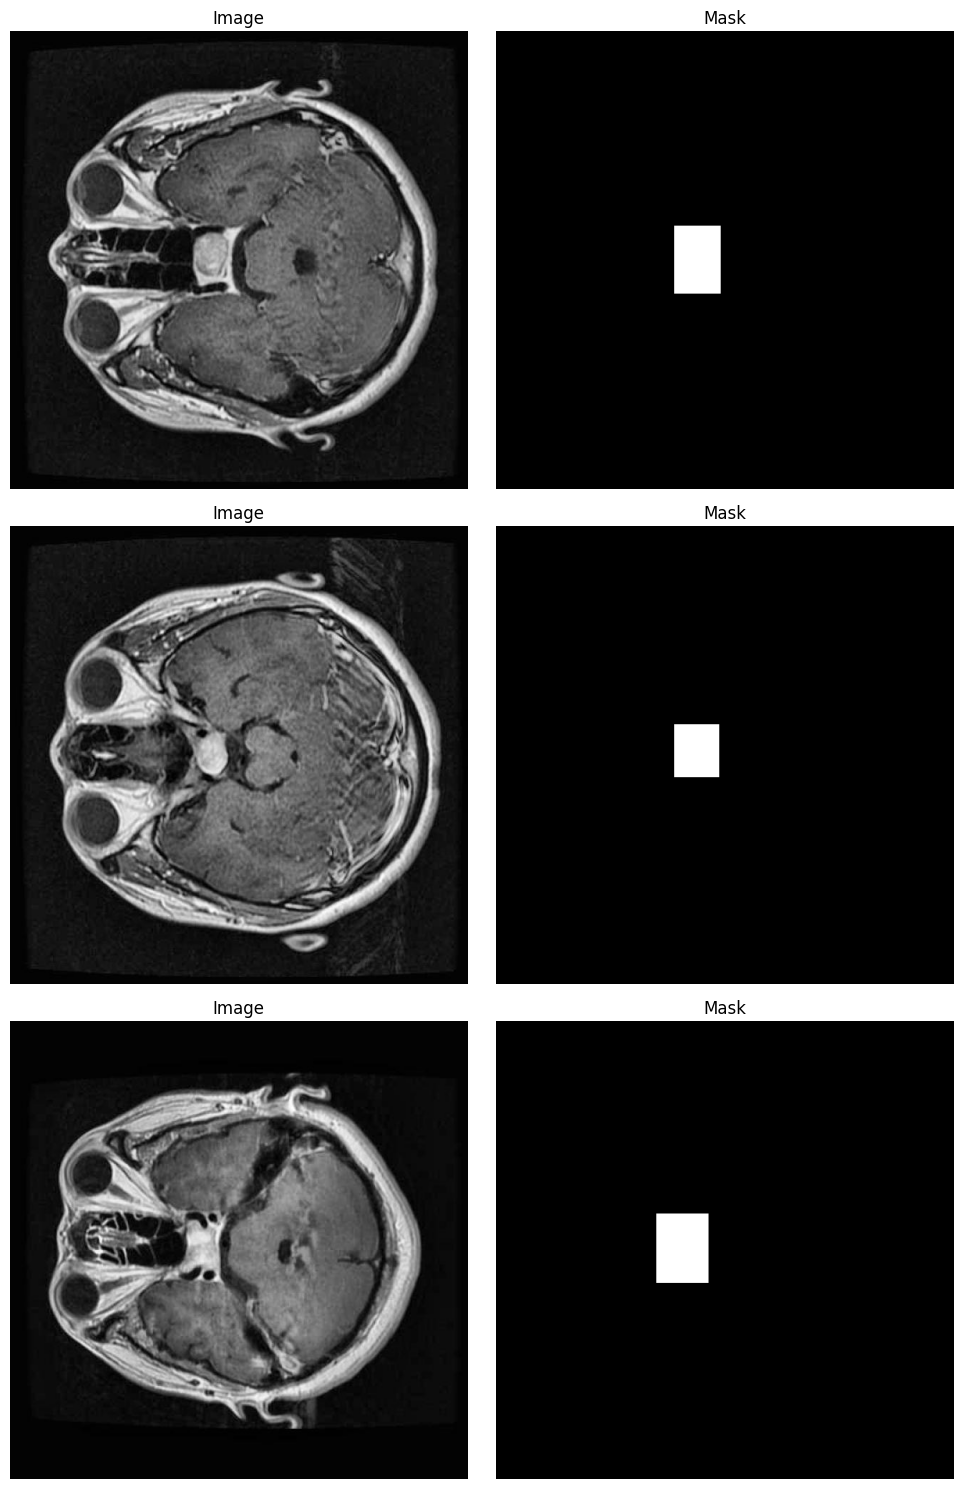

In [254]:
fig,axs = plt.subplots(3,2,figsize=(10,15))
for i in range(3):  # Plot the first three samples
    image, mask = dataset[i]
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()